<a href="https://colab.research.google.com/github/PratyushJha254/BTP/blob/main/Model_interpretations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import pickle
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
import matplotlib.cm as cm
from keras.utils import to_categorical
import keras.layers as layers
from keras import Sequential
from numba import jit

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import sys
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import seaborn as sns


In [2]:
nu_G = 10
Ny = 64
Nx = 64
nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs = 50
lr = 0.001
beta1 = 0.5
ngpu = 1
N = Ny * Nx
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

### Model

#### Accuracy, train and test functions

In [3]:
def calculate_accuracy(outputs, labels):
    # Threshold the outputs at 0.5 to get binary predictions: below 0.5 becomes 0, above becomes 1
    predicted = (outputs > 0.5).float()

    # The labels need to have the same dimensions as the predictions for comparison
    # Assuming labels are already in the correct shape (batch_size, 1) or (batch_size,)
    # If not, you might need to adjust labels' shape, e.g., labels = labels.view(-1, 1)

    # Calculate the number of correct predictions
    correct = (predicted == labels).float().sum().item()/2

    # Calculate the total number of labels (which is also the batch size)
    total = labels.size(0)

    # Calculate accuracy as the percentage of correct predictions
    accuracy = correct / total
    return accuracy


In [4]:
def train(model, num_epochs, criterion, optimizer, train_dataloader):
  for epoch in range(num_epochs):
    for i, (x, label) in enumerate(train_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      b_size = x.size(0)
      model.zero_grad()
      output = model(x)
      # if(epoch==0 and i==0):
      #   print(output)
      error = criterion(output, label)
      error.backward()
      optimizer.step()
      acc_train = calculate_accuracy(output, label)
      if i % 20 == 0:
        print('Loss:', error.item(),',Train accuracy:', acc_train)

In [5]:
def test(model, criterion, test_dataloader):
    for i, (x, label) in enumerate(test_dataloader):
      x = x.to(device).float()
      label = label.to(device).float()
      output = model(x)
      error = criterion(output, label)
      acc_train = calculate_accuracy(output, label)
      # if i % 20 == 0:
      print(i,':: Loss:', error.item(),',Test accuracy:', acc_train)

In [6]:
def get_predictions(test_loader, model):
    # Assuming `test_loader` is your DataLoader for the test dataset
    # Initialize lists to store predictions for each class
    predictions_class_1 = []
    predictions_class_2 = []

    with torch.no_grad():  # Disable gradient tracking during inference
        for inputs, _ in test_loader:
            inputs = inputs.to(device).float()  # Move inputs to the device (e.g., GPU)
            outputs = model(inputs)  # Forward pass to get predictions

            # Assuming the output is softmax probabilities
            # Separate the probabilities for class-1 and class-2
            class_1_probs = outputs[:, 0].cpu().numpy()  # Probabilities for class-1
            class_2_probs = outputs[:, 1].cpu().numpy()  # Probabilities for class-2

            predictions_class_1.extend(class_1_probs)
            predictions_class_2.extend(class_2_probs)

    # `predictions_class_1` contains the probabilities for class-1 for all test samples
    # `predictions_class_2` contains the probabilities for class-2 for all test samples
    # You can further process or save these predictions as needed
    return predictions_class_1, predictions_class_2


In [7]:
def get_predictions_np(input_matrix, model, device):
    # Convert numpy matrix to PyTorch tensor
    inputs = torch.tensor(input_matrix).to(device).float()

    # Forward pass to get predictions
    with torch.no_grad():  # Disable gradient tracking during inference
        outputs = model(inputs)  # Forward pass to get predictions

        # Assuming the output is softmax probabilities
        # Separate the probabilities for class-1 and class-2
        class_1_probs = outputs[:, 0].cpu().numpy()  # Probabilities for class-1
        class_2_probs = outputs[:, 1].cpu().numpy()  # Probabilities for class-2

    # `class_1_probs` contains the probabilities for class-1 for all samples
    # `class_2_probs` contains the probabilities for class-2 for all samples
    # You can further process or save these predictions as needed
    return class_1_probs, class_2_probs


#### File loaders

In [61]:
def file_loader(file_name, Tc = 2.27):
    data = np.load(file_name)
    X = data['X']
    y = data['y']
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15)
    Tc = 2.27 # For a square lattice following Ising Model
    y_train = Y_train > Tc
    y_test = Y_test > Tc
    y_train = to_categorical(y_train.astype(int))
    y_test = to_categorical(y_test.astype(int))
    return X_train, X_test, y_train, y_test, Y_train, Y_test

In [62]:
def full_file_loader(file_name, Tc = 2.27):
    data = np.load(file_name)
    X = data['X']
    Y = data['y']
    # Tc = 2.27 # For a square lattice following Ising Model
    y = Y > Tc
    y = to_categorical(y.astype(int))
    return X, y, Y

#### Dataset and DataLoader

In [10]:
class IsingDataset(Dataset):
    def __init__(self, x, y, anti_ferro=False):
        self.n_samples = x.shape[0]
        self.x = torch.tensor(torch.from_numpy(x))
        self.y = torch.tensor(torch.from_numpy(y))
        self.anti_ferro = anti_ferro

    def __getitem__(self, index):
        if self.anti_ferro:
            x_transformed = self._apply_anti_ferro(self.x[index])
            return x_transformed, self.y[index]
        else:
            return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

    def _apply_anti_ferro(self, x):
        # Apply anti-ferromagnetic transformation
        return (-1) ** torch.arange(x.size(0)).unsqueeze(1) + (-1) ** torch.arange(x.size(1))

# # Example usage
# x = ...  # Your input data
# y = ...  # Your target labels
# anti_ferro = True  # Set to True to apply the anti-ferromagnetic transformation
# dataset = IsingDataset(x, y, anti_ferro=anti_ferro)


Train and test data:

In [21]:
# Anti-ferromagnetic dataset: train and test

X_train_anti, X_test_anti, y_train_anti, y_test_anti, Y_train_anti, Y_test_anti = file_loader('data_anti.npz')

In [22]:
training_dataset_anti = IsingDataset(X_train_anti, y_train_anti)
testing_dataset_anti = IsingDataset(X_test_anti, y_test_anti)
batch_size = 128
train_dataloader_anti = DataLoader(dataset = training_dataset_anti, batch_size = batch_size, shuffle = False)
test_dataloader_anti = DataLoader(dataset = testing_dataset_anti, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [46]:
print("Class:", y_train_anti[10])
print("Temperature:", Y_train_anti[10])

Class: [1. 0.]
Temperature: 1.9


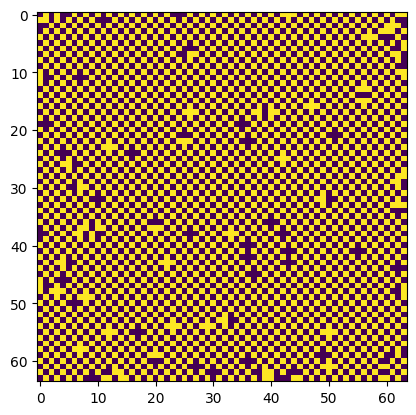

In [47]:
plt.imshow(X_train_anti[10])

#### Fully Connected Neural Network

In [29]:
class neural_network(nn.Module):
  def __init__(self):
    super(neural_network, self).__init__()
    self.main = nn.Sequential(
        nn.Flatten(start_dim=1,end_dim=-1),
        nn.Linear(Nx*Ny, 100),
        nn.Sigmoid(),
        nn.Linear(100, 2),
        nn.Sigmoid()
    )
  def forward(self, input):
      return self.main(input)

In [30]:
FCNN = neural_network().to(device)
criterion_FCNN = nn.BCELoss()
optimizer_FCNN = optim.Adam(FCNN.parameters(), lr=lr, betas=(0.9, 0.999))

In [ ]:
# # Dataset 1, NN -> antiFe, NNN -> Fe
# X_anti, y_anti, Y_anti = full_file_loader('data_anti.npz')
# dataset_anti = IsingDataset(X_anti, y_anti)
# batch_size = 128
# dataloader_anti = DataLoader(dataset = dataset_anti, batch_size = batch_size, shuffle = False)

<ipython-input-39-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-39-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [31]:
train(FCNN, 10, criterion_FCNN, optimizer_FCNN, train_dataloader_anti)

Loss: 0.6876479387283325 ,Train accuracy: 0.546875
Loss: 0.6931283473968506 ,Train accuracy: 0.47265625
Loss: 0.6957177519798279 ,Train accuracy: 0.59765625
Loss: 0.6825841069221497 ,Train accuracy: 0.3125
Loss: 0.6959665417671204 ,Train accuracy: 0.69140625
Loss: 0.6700637936592102 ,Train accuracy: 0.60546875
Loss: 0.6770510673522949 ,Train accuracy: 0.66796875
Loss: 0.6782938241958618 ,Train accuracy: 0.77734375
Loss: 0.6776275634765625 ,Train accuracy: 0.5625
Loss: 0.6313097476959229 ,Train accuracy: 0.8828125
Loss: 0.6322832703590393 ,Train accuracy: 0.59765625
Loss: 0.6284573674201965 ,Train accuracy: 0.82421875
Loss: 0.6185092329978943 ,Train accuracy: 0.8359375
Loss: 0.6177538633346558 ,Train accuracy: 0.80859375
Loss: 0.5875008702278137 ,Train accuracy: 0.8515625
Loss: 0.5802537798881531 ,Train accuracy: 0.84765625
Loss: 0.5761789679527283 ,Train accuracy: 0.8515625
Loss: 0.5980709791183472 ,Train accuracy: 0.84765625
Loss: 0.5667077302932739 ,Train accuracy: 0.8671875
Loss: 0.

In [32]:
test(FCNN, criterion_FCNN, test_dataloader_anti)

0 :: Loss: 0.4198528230190277 ,Test accuracy: 0.8515625
1 :: Loss: 0.35507187247276306 ,Test accuracy: 0.890625
2 :: Loss: 0.2963845729827881 ,Test accuracy: 0.8984375
3 :: Loss: 0.3349599838256836 ,Test accuracy: 0.8828125
4 :: Loss: 0.24811866879463196 ,Test accuracy: 0.91015625
5 :: Loss: 0.3799694776535034 ,Test accuracy: 0.8515625
6 :: Loss: 0.3863770365715027 ,Test accuracy: 0.89453125
7 :: Loss: 0.23530161380767822 ,Test accuracy: 0.9375
8 :: Loss: 0.22361020743846893 ,Test accuracy: 0.90625
9 :: Loss: 0.25119855999946594 ,Test accuracy: 0.8984375
10 :: Loss: 0.29407626390457153 ,Test accuracy: 0.8828125
11 :: Loss: 0.3150583803653717 ,Test accuracy: 0.88671875
12 :: Loss: 0.35631653666496277 ,Test accuracy: 0.90625
13 :: Loss: 0.3081590235233307 ,Test accuracy: 0.90625
14 :: Loss: 0.41661936044692993 ,Test accuracy: 0.85546875
15 :: Loss: 0.4445633292198181 ,Test accuracy: 0.8671875
16 :: Loss: 0.15099060535430908 ,Test accuracy: 0.953125
17 :: Loss: 0.2790911793708801 ,Test ac

#### CNN:

In [13]:
# model = Sequential([
#           layers.Reshape(target_shape=(40,40,1), input_shape=(40,40)),
#           layers.Conv2D(128, (3,3), padding='valid', activation='relu'),
#           layers.Flatten(),
#           layers.Dense(128, activation='relu'),
#           layers.Dropout(.5),
#           layers.Dense(2, activation='softmax')
#         ])
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, Nx, Ny):
        super(ConvNet, self).__init__()
        # Equivalent to Reshape in Keras, but in PyTorch, reshaping is typically done in the forward method.
        # Conv2D layer with 128 filters, kernel size of 3x3, padding='valid' implies no padding in PyTorch
        self.conv1 = nn.Conv2d(1, 64, kernel_size=2, padding=0)
        # Determine the output size of the first convolutional layer
        self.out_conv1 = self._calculate_output_size((Nx, Ny), kernel_size=2, padding=0)
        # Dense layer with 128 units
        self.fc1 = nn.Linear(64 * self.out_conv1[0] * self.out_conv1[1], 64)
        # Dropout layer with p=0.5
        self.dropout = nn.Dropout(p=0.5)
        # Output Dense layer with 2 units for softmax output
        self.fc2 = nn.Linear(64, 2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        # Reshape input to have one channel
        x = x.view(-1, 1, x.size(1), x.size(2))
        # Applying Convolutional Layer
        x = F.relu(self.conv1(x))
        # Flattening the output of the conv layer
        x = x.view(-1, 64 * self.out_conv1[0] * self.out_conv1[1])    # ------------------
        # Dense layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Dropout layer
        x = self.dropout(x)
        # Output layer with softmax activation
        return F.softmax(self.fc2(x))

    def _calculate_output_size(self, input_size, kernel_size, padding):
        # Calculate output size after convolutional layer
        out_size = [(input_size[0] - kernel_size + 2 * padding) + 1,
                    (input_size[1] - kernel_size + 2 * padding) + 1]
        return out_size


In [74]:
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['binary_accuracy'])
CNN = ConvNet(Nx, Ny).to(device)
criterion_CNN = nn.BCELoss()
optimizer_CNN = optim.Adam(CNN.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [75]:
train(CNN, 10, criterion_CNN, optimizer_CNN, train_dataloader_anti)

<ipython-input-13-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


Loss: 0.6922791004180908 ,Train accuracy: 0.53125
Loss: 0.020207084715366364 ,Train accuracy: 0.984375
Loss: 0.10165642946958542 ,Train accuracy: 0.984375
Loss: 0.059685833752155304 ,Train accuracy: 0.9921875
Loss: 0.018403541296720505 ,Train accuracy: 0.9921875
Loss: 0.011462502181529999 ,Train accuracy: 0.9921875
Loss: 0.020670343190431595 ,Train accuracy: 0.9921875
Loss: 0.011152057908475399 ,Train accuracy: 0.9921875
Loss: 0.06586307287216187 ,Train accuracy: 0.984375
Loss: 0.0192645862698555 ,Train accuracy: 0.9921875
Loss: 0.015852659940719604 ,Train accuracy: 0.9921875
Loss: 0.03045506775379181 ,Train accuracy: 0.9921875
Loss: 0.0063675930723547935 ,Train accuracy: 1.0
Loss: 0.009256459772586823 ,Train accuracy: 1.0
Loss: 0.0012420308776199818 ,Train accuracy: 1.0
Loss: 0.0060473959892988205 ,Train accuracy: 1.0
Loss: 0.005653879139572382 ,Train accuracy: 1.0
Loss: 0.032693177461624146 ,Train accuracy: 0.984375
Loss: 0.025758102536201477 ,Train accuracy: 0.9765625
Loss: 0.003652

In [76]:
test(CNN, criterion_CNN, test_dataloader_anti)

<ipython-input-13-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


0 :: Loss: 0.11614495515823364 ,Test accuracy: 0.984375
1 :: Loss: 0.03730158507823944 ,Test accuracy: 0.9765625
2 :: Loss: 0.0011313584400340915 ,Test accuracy: 1.0
3 :: Loss: 0.02025325410068035 ,Test accuracy: 0.984375
4 :: Loss: 0.039311014115810394 ,Test accuracy: 0.9921875
5 :: Loss: 0.06214701011776924 ,Test accuracy: 0.984375
6 :: Loss: 0.007940392941236496 ,Test accuracy: 0.9921875
7 :: Loss: 0.045885056257247925 ,Test accuracy: 0.984375
8 :: Loss: 0.0024380036629736423 ,Test accuracy: 1.0
9 :: Loss: 0.0029644090682268143 ,Test accuracy: 1.0
10 :: Loss: 0.08626677095890045 ,Test accuracy: 0.9765625
11 :: Loss: 0.06669402867555618 ,Test accuracy: 0.984375
12 :: Loss: 0.005725751165300608 ,Test accuracy: 1.0
13 :: Loss: 0.010306691750884056 ,Test accuracy: 0.9921875
14 :: Loss: 0.015333455055952072 ,Test accuracy: 0.9921875
15 :: Loss: 0.08322874456644058 ,Test accuracy: 0.984375
16 :: Loss: 0.00031545659294351935 ,Test accuracy: 1.0
17 :: Loss: 0.006311403587460518 ,Test accura

### Testing on NNN data

#### Loading the datasets and the trained model

In [ ]:
# Dataset 1, NN -> antiFe, NNN -> Fe
# X1, y1, Y1 = full_file_loader('data_64NNN_antiferroNN_ferroNNN_R2.npz')

In [ ]:
# Dataset 2, NN -> antiFe
# X2, y2, Y2 = full_file_loader('data_anti.npz')

In [63]:
# Dataset 3, NN -> antiFe, NNN -> Fe, reduced
X3, y3, Y3 = full_file_loader('data_64NNN_anti_noshuffle_reduced.npz', 8.5)

In [64]:
# dataset1 = IsingDataset(X1, y1)
# dataset2 = IsingDataset(X2, y2)
dataset3 = IsingDataset(X3, y3)
batch_size = 128
# dataloader1 = DataLoader(dataset = dataset1, batch_size = batch_size, shuffle = False)
# dataloader2 = DataLoader(dataset = dataset2, batch_size = batch_size, shuffle = False)
dataloader3 = DataLoader(dataset = dataset3, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [ ]:
FCNN.load_state_dict(torch.load('NeuralNetwork_weights_anti64.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

CNN

In [ ]:
dataset3.__len__()

2200

In [77]:
test(CNN, criterion_CNN, dataloader3)

0 :: Loss: 0.29558154940605164 ,Test accuracy: 0.8046875
1 :: Loss: 0.36221787333488464 ,Test accuracy: 0.7734375
2 :: Loss: 0.5728088617324829 ,Test accuracy: 0.640625
3 :: Loss: 1.1437149047851562 ,Test accuracy: 0.453125
4 :: Loss: 2.1804964542388916 ,Test accuracy: 0.2890625
5 :: Loss: 6.9383697509765625 ,Test accuracy: 0.0390625
6 :: Loss: 14.726797103881836 ,Test accuracy: 0.03125
7 :: Loss: 23.744009017944336 ,Test accuracy: 0.1875
8 :: Loss: 3.6306802940089256e-05 ,Test accuracy: 1.0
9 :: Loss: 4.2523242882452905e-06 ,Test accuracy: 1.0
10 :: Loss: 1.218090687871154e-06 ,Test accuracy: 1.0
11 :: Loss: 6.011301593389362e-06 ,Test accuracy: 1.0
12 :: Loss: 2.9521771693907795e-07 ,Test accuracy: 1.0
13 :: Loss: 7.926639227662235e-06 ,Test accuracy: 1.0
14 :: Loss: 1.3338017197384033e-06 ,Test accuracy: 1.0
15 :: Loss: 9.740622317622183e-07 ,Test accuracy: 1.0
16 :: Loss: 8.488352705171565e-07 ,Test accuracy: 1.0
17 :: Loss: 1.0601809360966108e-11 ,Test accuracy: 1.0


<ipython-input-13-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


In [79]:
pred_class1, pred_class2 = get_predictions(dataloader3, CNN)

<ipython-input-13-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


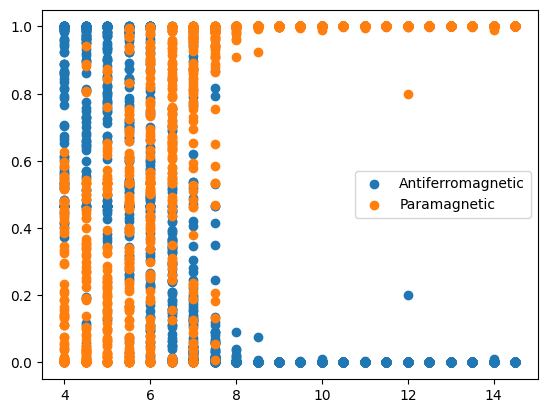

In [80]:
plt.scatter(Y3, pred_class1, label='Antiferromagnetic')
plt.scatter(Y3, pred_class2, label='Paramagnetic')
plt.legend()

FCNN

In [33]:
dataset3.__len__()

2200

In [81]:
test(FCNN, criterion_FCNN, dataloader3)

0 :: Loss: 1.7272565364837646 ,Test accuracy: 0.55859375
1 :: Loss: 1.6813437938690186 ,Test accuracy: 0.4140625
2 :: Loss: 2.280813455581665 ,Test accuracy: 0.37109375
3 :: Loss: 1.712501883506775 ,Test accuracy: 0.43359375
4 :: Loss: 1.4424455165863037 ,Test accuracy: 0.54296875
5 :: Loss: 1.9115322828292847 ,Test accuracy: 0.42578125
6 :: Loss: 2.667715072631836 ,Test accuracy: 0.328125
7 :: Loss: 2.931903600692749 ,Test accuracy: 0.3515625
8 :: Loss: 0.6326177716255188 ,Test accuracy: 0.7890625
9 :: Loss: 0.7200087308883667 ,Test accuracy: 0.8046875
10 :: Loss: 0.4871750771999359 ,Test accuracy: 0.796875
11 :: Loss: 0.8627126216888428 ,Test accuracy: 0.8125
12 :: Loss: 0.6343590021133423 ,Test accuracy: 0.75390625
13 :: Loss: 0.6946726441383362 ,Test accuracy: 0.76171875
14 :: Loss: 0.730778694152832 ,Test accuracy: 0.7578125
15 :: Loss: 0.8178161382675171 ,Test accuracy: 0.74609375
16 :: Loss: 0.6539164185523987 ,Test accuracy: 0.78125
17 :: Loss: 0.7420551180839539 ,Test accuracy

In [82]:
pred_class1, pred_class2 = get_predictions(dataloader3, FCNN)

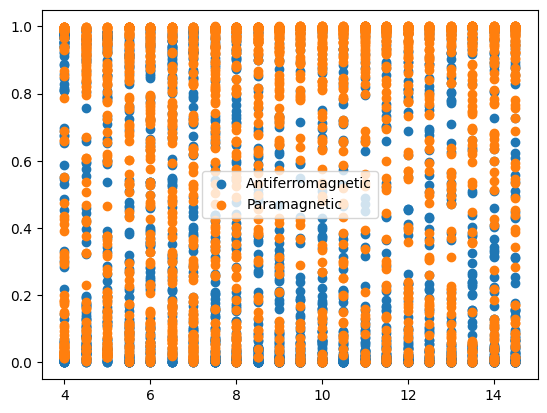

In [83]:
plt.scatter(Y3, pred_class1, label='Antiferromagnetic')
plt.scatter(Y3, pred_class2, label='Paramagnetic')
plt.legend()

#### Data Visualization

In [ ]:
for idx, i in enumerate(Y2):
  if i>3:
    print(idx)
    print(i)
    break

3
3.1


Text(0.5, 1.0, 'Temperature = 8.5, Class = [1. 0.]')

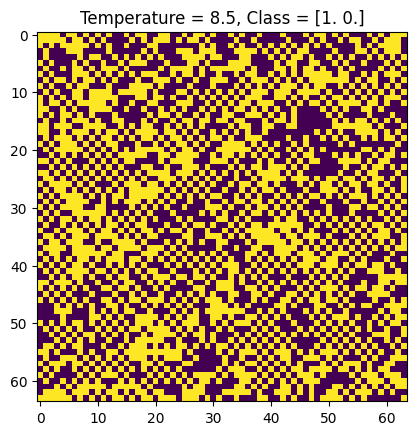

In [73]:
plt.imshow(X3[900])
plt.title(f"Temperature = {Y3[900]}, Class = {y3[900]}")

Text(0.5, 1.0, 'Temperature = 4.0')

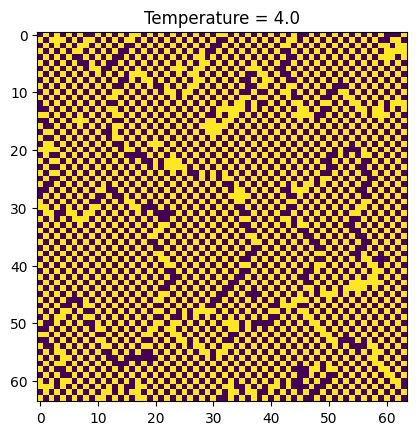

In [20]:
plt.imshow(X3[0])
plt.title(f"Temperature = {Y3[0]}")

In [ ]:
# Class 1 -> Paramagnetic, Class 2 -> Antiferromagnetic ([0. 1.] -> AFM)
## Samples getting predicted incorrectly:
for index in range(dataset3.__len__()):
    if(np.round(pred_class1[index]) != y3[index][0]):
        print(f"\033[1mIndex: {index}\033[0m")
        print(f"PREDICTED: {pred_class1[index]}, {pred_class2[index]}")
        print(f"EXPECTED: {y3[index]}")

---
A few datapoints from the above printed data: <br>
<small><b>Index: 1</b> <br>
PREDICTED: 0.5311572551727295, 0.4595322012901306 <br>
EXPECTED: [0. 1.]<br>
<b>Index: 12</b><br>
PREDICTED: 0.723466694355011, 0.26100102066993713<br>
EXPECTED: [0. 1.]<br>
<b>Index: 13 </b><br>
PREDICTED: 0.8141891360282898, 0.19164887070655823<br>
EXPECTED: [0. 1.]<br></small>

PREDICTED: 0.02166641131043434, 0.971859335899353
EXPECTED: [0. 1.]


Text(0.5, 1.0, 'Temperature = 4.0')

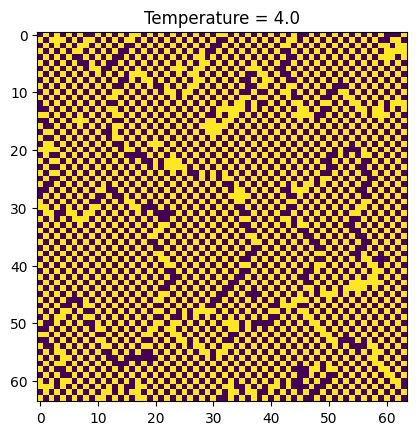

In [ ]:
index = 0
print(f"PREDICTED: {pred_class1[index]}, {pred_class2[index]}")
print(f"EXPECTED: {y3[index]}")
plt.imshow(X3[index])
plt.title(f"Temperature = {Y3[index]}")

PREDICTED: 0.8141891360282898, 0.19164887070655823
EXPECTED: [0. 1.]


Text(0.5, 1.0, 'Temperature = 4.0')

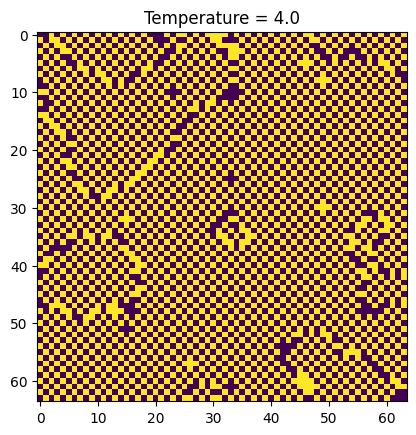

In [ ]:
index = 13
print(f"PREDICTED: {pred_class1[index]}, {pred_class2[index]}")
print(f"EXPECTED: {y3[index]}")
plt.imshow(X3[index])
plt.title(f"Temperature = {Y3[index]}")

To check if the model correctly predicts a perfectly anti-ferromagnetic lattice

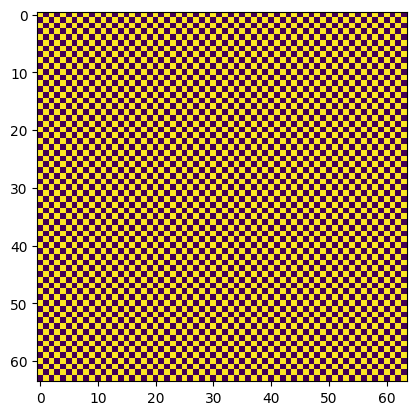

In [37]:
test_input1 = np.ones((1, 64, 64))  # Add an additional dimension for batch size of 1
test_input1[:, 1::2, ::2] = -1
test_input1[:, ::2, 1::2] = -1

plt.imshow(test_input1.squeeze())  # Squeeze the batch dimension for visualization
plt.show()

CNN

In [38]:
# Resolve the error
pred_c1, pred_c2 = get_predictions_np(test_input1, CNN, device)

<ipython-input-13-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


In [39]:
print(f"{pred_c1}, {pred_c2}")

[1.], [1.1239331e-12]


FCNN

In [40]:
# Resolve the error
pred_c1, pred_c2 = get_predictions_np(test_input1, FCNN, device)

In [41]:
print(f"{pred_c1}, {pred_c2}")

[0.9846149], [0.01495955]


TO-DO List:
1. Print class attribution maps
2. Transfer learning in FCNN
3. Check for CNN

---
---


#### Train a CNN on NNN data


In [84]:
# Anti-ferromagnetic dataset: train and test

X3_train, X3_test, y3_train, y3_test, Y3_train, Y3_test = file_loader('data_64NNN_anti_noshuffle_reduced.npz', 8.5)

In [85]:
training_dataset3 = IsingDataset(X3_train, y3_train)
testing_dataset3 = IsingDataset(X3_test, y3_test)
batch_size = 128
train_dataloader3 = DataLoader(dataset = training_dataset3, batch_size = batch_size, shuffle = False)
test_dataloader3 = DataLoader(dataset = testing_dataset3, batch_size = batch_size, shuffle = False)

<ipython-input-10-2d1bccbc4b53>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(torch.from_numpy(x))
<ipython-input-10-2d1bccbc4b53>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(torch.from_numpy(y))


In [89]:
CNN_NNN = ConvNet(Nx, Ny).to(device)
criterion_CNN_NNN = nn.BCELoss()
optimizer_CNN_NNN = optim.Adam(CNN_NNN.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [90]:
train(CNN_NNN, 10, criterion_CNN_NNN, optimizer_CNN_NNN, train_dataloader3)

<ipython-input-13-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


Loss: 0.6628439426422119 ,Train accuracy: 0.6796875
Loss: 3.975001107621185e-15 ,Train accuracy: 1.0
Loss: 5.2653908922460834e-18 ,Train accuracy: 1.0
Loss: 1.7489364241339382e-17 ,Train accuracy: 1.0
Loss: 4.7070643274158585e-17 ,Train accuracy: 1.0
Loss: 6.212670449240576e-21 ,Train accuracy: 1.0
Loss: 3.736870004358564e-21 ,Train accuracy: 1.0
Loss: 1.2790432216038747e-18 ,Train accuracy: 1.0
Loss: 2.983737146212863e-19 ,Train accuracy: 1.0
Loss: 1.7660018880898462e-16 ,Train accuracy: 1.0


In [91]:
test(CNN_NNN, criterion_CNN_NNN, test_dataloader3)

0 :: Loss: 7.121848243021054e-23 ,Test accuracy: 1.0
1 :: Loss: 1.526085232084884e-16 ,Test accuracy: 1.0
2 :: Loss: 1.2620517153040522e-13 ,Test accuracy: 1.0


<ipython-input-13-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


In [92]:
# Other way round it is not working
test(CNN_NNN, criterion_CNN_NNN, test_dataloader_anti)

<ipython-input-13-341eff41c761>:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.fc2(x))


0 :: Loss: 37.17237854003906 ,Test accuracy: 0.578125
1 :: Loss: 39.872161865234375 ,Test accuracy: 0.546875
2 :: Loss: 44.020572662353516 ,Test accuracy: 0.5
3 :: Loss: 44.79127883911133 ,Test accuracy: 0.5
4 :: Loss: 42.041595458984375 ,Test accuracy: 0.5234375
5 :: Loss: 41.87174987792969 ,Test accuracy: 0.53125
6 :: Loss: 41.75581741333008 ,Test accuracy: 0.53125
7 :: Loss: 47.38581848144531 ,Test accuracy: 0.4609375
8 :: Loss: 50.064476013183594 ,Test accuracy: 0.4375
9 :: Loss: 46.29566192626953 ,Test accuracy: 0.4765625
10 :: Loss: 50.66930389404297 ,Test accuracy: 0.421875
11 :: Loss: 43.111297607421875 ,Test accuracy: 0.5078125
12 :: Loss: 42.2779655456543 ,Test accuracy: 0.5234375
13 :: Loss: 43.29917907714844 ,Test accuracy: 0.515625
14 :: Loss: 39.417694091796875 ,Test accuracy: 0.5546875
15 :: Loss: 42.808807373046875 ,Test accuracy: 0.515625
16 :: Loss: 42.911128997802734 ,Test accuracy: 0.515625
17 :: Loss: 36.57139205932617 ,Test accuracy: 0.5859375
18 :: Loss: 39.55314